In [67]:
import math
import numpy as np
import pandas as pd
import itertools
import joblib
from copy import deepcopy
import matplotlib.pyplot as plt
import time
import pickle
%matplotlib inline

In [162]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, learning_curve, ShuffleSplit 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
    f1_score, confusion_matrix, roc_auc_score, roc_curve, log_loss
from sklearn.neural_network._base import logistic, relu
from sklearn.metrics import 
from sklearn.neural_network import MLPClassifier

In [124]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, 
                        train_sizes=np.linspace(.1, 1.0, 5), figsize=(10,8)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=figsize)
    #plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [128]:
def plot_roc_curve(title, labels, predictions, figsize=(10, 8)):
    
    fpr, tpr, thrsh = roc_curve(labels, predictions)
    roc_auc = roc_auc_score(labels, predictions)
    
    plt.figure(figsize=figsize)
    plt.grid()
    plt.plot(fpr, tpr, color='b', label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('{} Receiver Operating Characteristic'.format(title))
    plt.legend()

In [130]:
def plot_fitness_time(solutions):
    times = [sol[2] for sol in solutions]
    costs = [sol[0] for sol in solutions]
    plt.figure(figsize=(10, 8))
    plt.ylabel('Fitness (inverse log loss)')
    plt.xlabel('Time (s)')
    #plt.title('QSD for {} with {}'.format(city, alg))
    #plt.ylim(0, 1)
    plt.grid(True)
    plt.plot(times, costs)

In [6]:
class ff_nn:
    
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, activation=relu, output=logistic, loss=log_loss):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.activation = activation
        self.output = output
        self.indexes = [input_dim * hidden_layer_sizes[0]]
        self.loss = loss
        for i in range(1, len(hidden_layer_sizes)):
            self.indexes.append(self.indexes[i-1] + hidden_layer_sizes[i-1] * hidden_layer_sizes[i])
        self.indexes.append(self.indexes[-1] + hidden_layer_sizes[-1] * output_dim)
        for i in range(len(hidden_layer_sizes)):
            self.indexes.append(self.indexes[-1] + hidden_layer_sizes[i])
        #self.indexes.append(self.indexes[-1] + output_dim)
        
    def reshape_params(self, w):
        weights = [np.reshape(w[:self.indexes[0]], (self.input_dim, self.hidden_layer_sizes[0]))]
        for i in range(len(self.hidden_layer_sizes)-1):
            weights.append(np.reshape(w[self.indexes[i]:self.indexes[i+1]], (self.hidden_layer_sizes[i], self.hidden_layer_sizes[i])))
        weights.append(np.reshape(w[self.indexes[(i+1)]:self.indexes[(i+2)]], (self.hidden_layer_sizes[-1], self.output_dim)))
        biases = []
        for i in range(len(self.hidden_layer_sizes), 2*len(self.hidden_layer_sizes)):
            biases.append(np.reshape(w[self.indexes[i]:self.indexes[i+1]], (1, -1)))
        biases.append(np.reshape(w[self.indexes[i+1]:], (1, -1)))
        return weights, biases
        
    def predict(self, x, w):
        weights, biases = self.reshape_params(w)
        a = self.activation(np.matmul(x, weights[0]) + biases[0])
        for i in range(1, len(self.hidden_layer_sizes)):
            a = self.activation(np.matmul(a, weights[i]) + biases[i])
        return logistic(np.matmul(a, weights[-1]) + biases[-1])
    
    def score(self, x, y, w):
        y_pred = self.predict(x, w)
        return 1 / self.loss(y, y_pred)

In [73]:
def hill_climbing(net, size, x, y, mean, std, n_iter, n_restarts):
    
    start = time.time()
    
    best_params = np.zeros(size)
    best_cost = float('-inf')
    solutions = []
    
    for i in range(n_restarts):
        curr_params = np.random.normal(mean, std, size)
        curr_cost = net.score(x, y, curr_params)
        
        if curr_cost > best_cost:
            best_params = np.array(curr_params)
            best_cost = curr_cost
            solutions.append((best_cost, best_params, time.time()-start))
            
        print('initial cost of start {}: {}'.format(i+1, curr_cost))
        
#         improving = True
#         while improving:
#             improving = False
#             index = np.random.choice(size)
#             neighbors = np.random.normal(mean, 1, 100)
#             for neighbor in neighbors:
#                 new_params = np.array(curr_params)
#                 new_params[index] = neighbor
#                 new_cost = net.score(x, y, new_params)
#                 if new_cost > curr_cost:
#                     curr_params = np.array(new_params)
#                     curr_cost = new_cost
#                     improving = True
#                     if curr_cost > best_cost:
#                         best_params = np.array(curr_params)
#                         best_cost = curr_cost
#                         solutions.append((best_cost, best_params))
        
        for j in range(n_iter):
            index = np.random.choice(size)
            new_params = np.array(curr_params)
            new_params[index] += np.random.normal(mean, std)
            new_cost = net.score(x, y, new_params)
            if new_cost > curr_cost:
                curr_params = np.array(new_params)
                curr_cost = new_cost
                if curr_cost > best_cost:
                    best_params = np.array(curr_params)
                    best_cost = curr_cost
                    solutions.append((best_cost, best_params, time.time()-start))
                    
            if j > 0 and j % 1000 == 0:
                print('best cost after {} iterations: {}'.format(j, best_cost))
                print('current cost after {} iterations: {}'.format(j, curr_cost))
                print('-------------------')
                
        print('best cost after start {}: {}'.format(i+1, best_cost))
        print('-------------------')
        print('-------------------')
        
    return solutions

In [70]:
def simulated_annealing(net, size, x, y, mean, std, temp, final_temp, cooling_factor, max_iter):
    
    start = time.time()

    curr_params = np.random.normal(mean, std, size)
    curr_cost = net.score(x, y, curr_params)
    
    best_params = np.array(curr_params)
    best_cost = curr_cost
    solutions = [(best_cost, best_params, time.time()-start)]
    
    n_iter = 0
    n_accept = 0
    
    print('initial cost: {}'.format(best_cost))
    print('-------------------')
    
    while temp > final_temp and n_iter < max_iter:
        index = np.random.choice(size)
        neighbors = np.random.normal(mean, std, 6)
        for neighbor in neighbors:
            new_params = np.array(curr_params)
            new_params[index] += neighbor
            new_cost = net.score(x, y, new_params)
            #diff = ((new_cost - curr_cost) / new_cost) * 10
            diff = (new_cost - curr_cost) * 1000
    #         print('new cost {}'.format(new_cost))
    #         print('old cost {}'.format(curr_cost))
    #         print('diff {}'.format(diff))
    #         print('prob {}'.format(np.exp(diff/temp)))
    #         print('---------------------')
            if diff > 0:
                curr_params = np.array(new_params)
                curr_cost = new_cost
                if curr_cost > best_cost:
                    best_params = np.array(curr_params)
                    best_cost = curr_cost
                    solutions.append((best_cost, best_params, time.time()-start))
            elif np.exp(diff/temp) >= np.random.random():
                curr_params = np.array(new_params)
                curr_cost = new_cost
                if curr_cost > best_cost:
                    best_params = np.array(curr_params)
                    best_cost = curr_cost
                    solutions.append((best_cost, best_params, time.time()-start))
                n_accept += 1
                
        temp *= cooling_factor
        n_iter += 1
             
        if n_iter > 0 and n_iter % 1000 == 0:
            print('best cost after {} iterations: {}'.format(n_iter, best_cost))
            print('current cost after {} iterations: {}'.format(n_iter, curr_cost))
#             print('last diff: {}'.format(diff))
#             print('bad samples accepted: {}'.format(n_accept))
#             print(np.exp(diff/temp))
            print('-------------------')
            
    print('final temp after {} iterations: {:.8f}'.format(n_iter, temp))
        
    return solutions

In [71]:
def genetic_algorithm(net, size, x, y, mean, std, pop_size, generations, mutation_rate):
    
    def cull_population(fitnesses, pop, pop_size):
        order = np.argsort(fitnesses)
        fitnesses = np.sort(fitnesses)[-pop_size:]
        #fitnesses /= np.sum(fitnesses)
        pop = pop[order][-pop_size:]
        return pop, fitnesses
    
    def crossover(fitnesses, pop, pop_size, probs):
        all_parents = [(np.random.choice(range(pop_size), size=1, replace=False, p=probs)[0], np.random.choice(range(pop_size), size=1, replace=False, p=probs)[0]) for i in range(pop_size//2)]
        children = []
        child_fitnesses = []
        for parent_1, parent_2 in all_parents:
            child_1 = np.zeros(size)
            child_2 = np.zeros(size)
            for i in range(size):
                if np.random.random() > 0.5:
                    child_1[i] = pop[parent_1][i]
                    child_2[i] = pop[parent_2][i]
                else:
                    child_1[i] = pop[parent_2][i]
                    child_2[i] = pop[parent_1][i]
            children.append(child_1)
            children.append(child_2)
            child_fitnesses.append(net.score(x, y, child_1))
            child_fitnesses.append(net.score(x, y, child_2))
            
        to_mutate = np.random.choice(len(children), int(mutation_rate*len(children)), replace=False)
        for child in to_mutate:
            mutations = np.random.choice(size, int(mutation_rate*size), replace=False)
            children[child][mutations] += np.random.normal(0, 0.1, len(mutations))
            child_fitnesses[child] = net.score(x, y, children[child])
            
        pop = np.concatenate([pop, children])
        fitnesses = np.concatenate([fitnesses, child_fitnesses])
        
        return pop, fitnesses
    
    start = time.time()
     
    pop = np.zeros((pop_size, size))
    fitnesses = np.zeros(pop_size)
    for i in range(pop_size):
        params = np.random.normal(0, 0.1, size)
        cost = net.score(x, y, params)
        pop[i, :] = params
        fitnesses[i] = cost
        
    pop, fitnesses = cull_population(fitnesses, pop, pop_size)
    probs = fitnesses / sum(fitnesses)
    
    best_params = pop[np.argmax(fitnesses)]
    best_cost = net.score(x, y, best_params)
    solutions = [(best_cost, best_params, time.time()-start)]
    
    print('initial cost: {}'.format(best_cost))
        
    for i in range(generations):
        pop, fitnesses = crossover(fitnesses, pop, pop_size, probs)
        pop, fitnesses = cull_population(fitnesses, pop, pop_size)
        probs = fitnesses / sum(fitnesses)
        new_params = pop[np.argmax(fitnesses)]
        new_cost = np.max(fitnesses)
        if new_cost > best_cost:
            best_params = np.array(new_params)
            best_cost = new_cost
            solutions.append((best_cost, best_params, time.time()-start))
        print('best cost after generation {}: {}'.format(i+1, best_cost))
        
    return solutions

# Data

In [10]:
df = pd.read_csv('eye_data.txt', sep=',')
x = df.drop('eye', axis=1)
y = df[['eye']]

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=True, random_state=24)

In [12]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [13]:
input_dim = x.shape[1]
hidden_1 = 64
hidden_2 = 64
output_dim = y.shape[1]

In [14]:
my_nn = ff_nn(input_dim, (hidden_1, hidden_2), output_dim)

In [15]:
dims = [input_dim, hidden_1, hidden_2, output_dim]

In [16]:
n_params = 0
for i in range(1, len(dims)):
    n_params += dims[i] * dims[i-1] + dims[i]

# Hill Climbing

In [85]:
hc_solutions = hill_climbing(my_nn, n_params, x_train, y_train, 0, 0.1, 10000, 10)

initial cost of start 1: 1.4366278402351496
best cost after 1000 iterations: 1.4589581566048542
current cost after 1000 iterations: 1.4589581566048542
-------------------
best cost after 2000 iterations: 1.4772488140459445
current cost after 2000 iterations: 1.4772488140459445
-------------------
best cost after 3000 iterations: 1.4972393826216772
current cost after 3000 iterations: 1.4972393826216772
-------------------
best cost after 4000 iterations: 1.5143520545158606
current cost after 4000 iterations: 1.5143520545158606
-------------------
best cost after 5000 iterations: 1.5357055784683054
current cost after 5000 iterations: 1.5357055784683054
-------------------
best cost after 6000 iterations: 1.5529664116961974
current cost after 6000 iterations: 1.5529664116961974
-------------------
best cost after 7000 iterations: 1.5702162225681184
current cost after 7000 iterations: 1.5702162225681184
-------------------
best cost after 8000 iterations: 1.5949646213368365
current cost af

best cost after 6000 iterations: 1.6496404350043892
current cost after 6000 iterations: 1.5372730183980357
-------------------
best cost after 7000 iterations: 1.6496404350043892
current cost after 7000 iterations: 1.5539000993707504
-------------------
best cost after 8000 iterations: 1.6496404350043892
current cost after 8000 iterations: 1.5687020972753323
-------------------
best cost after 9000 iterations: 1.6496404350043892
current cost after 9000 iterations: 1.589499990145817
-------------------
best cost after start 7: 1.6496404350043892
-------------------
-------------------
initial cost of start 8: 1.404551523783727
best cost after 1000 iterations: 1.6496404350043892
current cost after 1000 iterations: 1.4282278382392668
-------------------
best cost after 2000 iterations: 1.6496404350043892
current cost after 2000 iterations: 1.4493390203301786
-------------------
best cost after 3000 iterations: 1.6496404350043892
current cost after 3000 iterations: 1.471405632636979
------

In [86]:
hc_cost, hc_params, hc_time = hc_solutions[-1]

In [87]:
hc_cost

1.6496404350043892

In [88]:
hc_pred = my_nn.predict(x_test, hc_params)

In [89]:
hc_pred = np.where(hc_pred>=0.5, 1, 0)

In [90]:
hc_cm = confusion_matrix(y_test, hc_pred)
hc_cm

array([[983, 291],
       [422, 551]], dtype=int64)

In [91]:
hc_acc = accuracy_score(y_test, hc_pred)
hc_acc

0.682688028482421

In [92]:
hc_prec = precision_score(y_test, hc_pred)
hc_prec

0.6543942992874109

In [93]:
hc_rec = recall_score(y_test, hc_pred)
hc_rec

0.566289825282631

In [94]:
hc_f1 = f1_score(y_test, hc_pred)
hc_f1

0.6071625344352617

In [109]:
with open('hc_solutions.pickle', 'wb') as f:
    pickle.dump(hc_solutions, f)

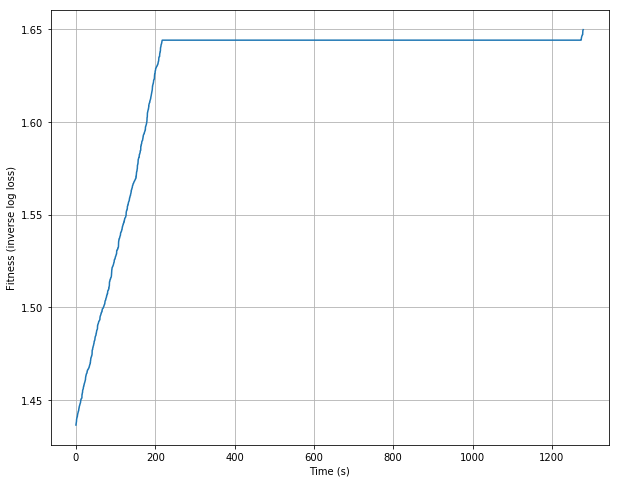

In [131]:
plot_fitness_time(hc_solutions)

# Simulated Annealing

In [132]:
sa_solutions = simulated_annealing(my_nn, n_params, x_train, y_train, 0, 0.1, 1, 1e-5, 0.999, 50000)

initial cost: 1.4323371367252973
-------------------
best cost after 1000 iterations: 1.472335749765275
current cost after 1000 iterations: 1.472307642186499
-------------------
best cost after 2000 iterations: 1.5510600214329644
current cost after 2000 iterations: 1.5508492485690195
-------------------
best cost after 3000 iterations: 1.6275251690784238
current cost after 3000 iterations: 1.6274659879955795
-------------------
best cost after 4000 iterations: 1.7337273743404333
current cost after 4000 iterations: 1.7337238285229468
-------------------
best cost after 5000 iterations: 1.8374413572272943
current cost after 5000 iterations: 1.8374357431572026
-------------------
best cost after 6000 iterations: 1.942417205318071
current cost after 6000 iterations: 1.942417205318071
-------------------
best cost after 7000 iterations: 2.0235383479935085
current cost after 7000 iterations: 2.0235383479935085
-------------------
best cost after 8000 iterations: 2.1115859374347883
current co

In [133]:
sa_cost, sa_params, sa_time = sa_solutions[-1]

In [134]:
sa_cost

2.4003485129461004

In [135]:
sa_time

1497.850402355194

In [136]:
sa_pred = my_nn.predict(x_test, sa_params)

In [137]:
sa_pred = np.where(sa_pred>=0.5, 1, 0)

In [138]:
sa_cm = confusion_matrix(y_test, sa_pred)
sa_cm

array([[1056,  218],
       [ 230,  743]], dtype=int64)

In [139]:
sa_acc = accuracy_score(y_test, sa_pred)
sa_acc

0.8006230529595015

In [140]:
sa_prec = precision_score(y_test, sa_pred)
sa_prec

0.7731529656607701

In [141]:
sa_rec = recall_score(y_test, sa_pred)
sa_rec

0.763617677286742

In [142]:
sa_f1 = f1_score(y_test, sa_pred)
sa_f1

0.7683557394002068

In [143]:
with open('sa_solutions.pickle', 'wb') as f:
    pickle.dump(sa_solutions, f)

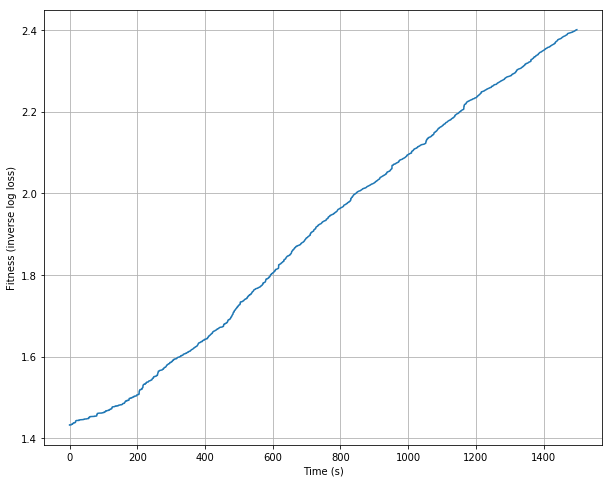

In [144]:
plot_fitness_time(sa_solutions)

# Genetic Algorithm

In [146]:
ga_solutions = genetic_algorithm(my_nn, n_params, x_train, y_train, 0, 0.1, 200, 500, 0.1)

initial cost: 1.4576214714849622
best cost after generation 1: 1.4596943508356586
best cost after generation 2: 1.4619894338338542
best cost after generation 3: 1.4619894338338542
best cost after generation 4: 1.4619894338338542
best cost after generation 5: 1.4619894338338542
best cost after generation 6: 1.4619894338338542
best cost after generation 7: 1.4619894338338542
best cost after generation 8: 1.4619894338338542
best cost after generation 9: 1.4619894338338542
best cost after generation 10: 1.4619894338338542
best cost after generation 11: 1.4646308873027503
best cost after generation 12: 1.4646308873027503
best cost after generation 13: 1.4646308873027503
best cost after generation 14: 1.4646308873027503
best cost after generation 15: 1.4646308873027503
best cost after generation 16: 1.4646308873027503
best cost after generation 17: 1.4646308873027503
best cost after generation 18: 1.4646308873027503
best cost after generation 19: 1.472184641314659
best cost after generation 

best cost after generation 165: 1.5813244283939076
best cost after generation 166: 1.5855762640214877
best cost after generation 167: 1.5855762640214877
best cost after generation 168: 1.5887394231342098
best cost after generation 169: 1.5887394231342098
best cost after generation 170: 1.5887394231342098
best cost after generation 171: 1.5887394231342098
best cost after generation 172: 1.590709968167227
best cost after generation 173: 1.590709968167227
best cost after generation 174: 1.590709968167227
best cost after generation 175: 1.593312653288764
best cost after generation 176: 1.5969570377801428
best cost after generation 177: 1.5969570377801428
best cost after generation 178: 1.5969570377801428
best cost after generation 179: 1.5985456601059924
best cost after generation 180: 1.6001219004633518
best cost after generation 181: 1.6001219004633518
best cost after generation 182: 1.6006894830168614
best cost after generation 183: 1.6068994915527441
best cost after generation 184: 1.6

best cost after generation 327: 1.7767930712088404
best cost after generation 328: 1.7767930712088404
best cost after generation 329: 1.784096055971739
best cost after generation 330: 1.784096055971739
best cost after generation 331: 1.7844199281178525
best cost after generation 332: 1.7844199281178525
best cost after generation 333: 1.7844199281178525
best cost after generation 334: 1.7844199281178525
best cost after generation 335: 1.7853157154051091
best cost after generation 336: 1.7858361982144104
best cost after generation 337: 1.78702074063785
best cost after generation 338: 1.78702074063785
best cost after generation 339: 1.7916162502288924
best cost after generation 340: 1.7916162502288924
best cost after generation 341: 1.7916162502288924
best cost after generation 342: 1.7916162502288924
best cost after generation 343: 1.7916162502288924
best cost after generation 344: 1.7916162502288924
best cost after generation 345: 1.7918908192591692
best cost after generation 346: 1.792

best cost after generation 489: 1.8708884746403367
best cost after generation 490: 1.8715607990742058
best cost after generation 491: 1.8715607990742058
best cost after generation 492: 1.8722845555851944
best cost after generation 493: 1.8722845555851944
best cost after generation 494: 1.8738300043140164
best cost after generation 495: 1.8738300043140164
best cost after generation 496: 1.8741887489977633
best cost after generation 497: 1.8741887489977633
best cost after generation 498: 1.8741887489977633
best cost after generation 499: 1.8748198261532618
best cost after generation 500: 1.8748198261532618


In [147]:
ga_cost, ga_params, ga_time = ga_solutions[-1]

In [152]:
ga_cost

1.8748198261532618

In [148]:
ga_pred = my_nn.predict(x_test, ga_params)

In [149]:
ga_pred = np.where(ga_pred>=0.5, 1, 0)

In [150]:
ga_cm = confusion_matrix(y_test, ga_pred)
ga_cm

array([[964, 310],
       [319, 654]], dtype=int64)

In [151]:
ga_acc = accuracy_score(y_test, ga_pred)
ga_acc

0.7200712060525145

In [153]:
ga_prec = precision_score(y_test, ga_pred)
ga_prec

0.6784232365145229

In [154]:
ga_rec = recall_score(y_test, ga_pred)
ga_rec

0.6721479958890031

In [155]:
ga_f1 = f1_score(y_test, ga_pred)
ga_f1

0.675271037687145

In [156]:
with open('ga_solutions.pickle', 'wb') as f:
    pickle.dump(ga_solutions, f)

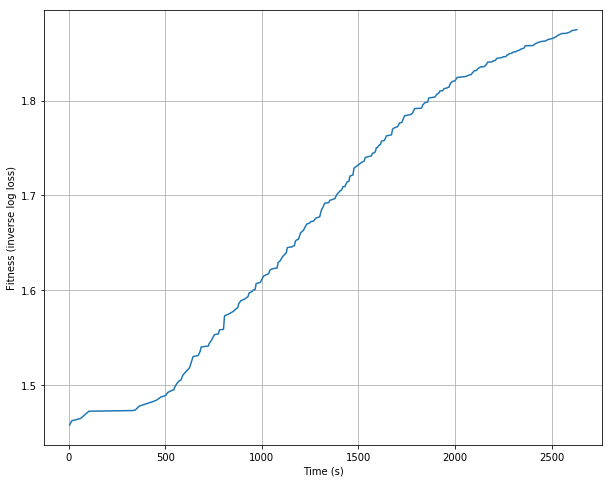

In [157]:
plot_fitness_time(ga_solutions)

# Backpropagation

In [95]:
ann = MLPClassifier((64, 64), activation='relu', solver='adam')

In [158]:
start = time.time()
ann.fit(x_train, np.reshape(y_train.values, (-1,)))
time.time() - start

C:\Users\Trace\Anaconda3\envs\supervised\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


10.03426718711853

In [97]:
ann_cost = 1 / log_loss(y_train, ann.predict_proba(x_train)[:, 1])
ann_cost

5.3551716828263025

[learning_curve] Training set sizes: [ 1018  3310  5602  7894 10186]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.1min finished


<module 'matplotlib.pyplot' from 'C:\\Users\\Trace\\Anaconda3\\envs\\supervised\\lib\\site-packages\\matplotlib\\pyplot.py'>

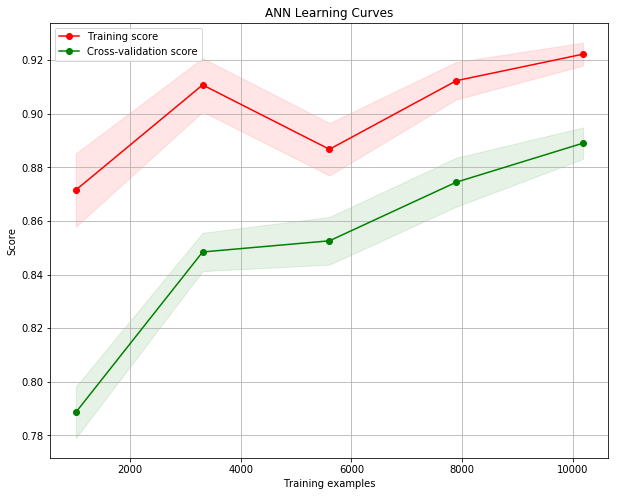

In [101]:
ann_title = 'ANN Learning Curves'
ann_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=24)
plot_learning_curve(ann, ann_title, x_train, y_train.values.reshape(-1), cv=ann_cv, n_jobs=4, figsize=(10,8))

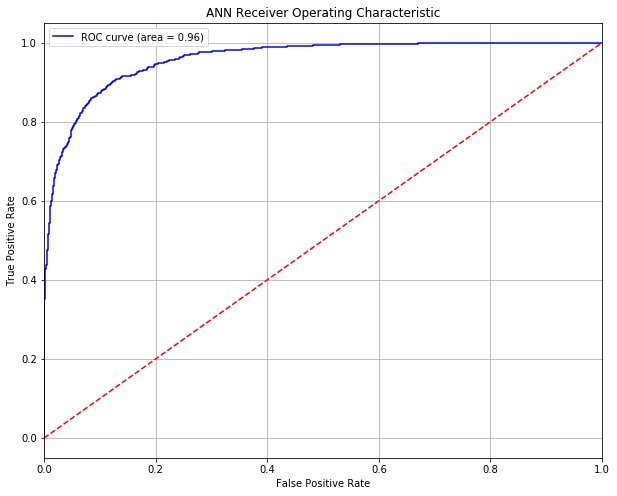

In [102]:
plot_roc_curve('ANN', y_test, ann.predict_proba(x_test)[:, 1])

In [103]:
ann_pred = ann.predict(x_test)

In [104]:
ann_cm = confusion_matrix(y_test, ann_pred)
ann_cm

array([[1133,  141],
       [ 113,  860]], dtype=int64)

In [105]:
ann_acc = accuracy_score(y_test, ann_pred)
ann_acc

0.8869603916332889

In [106]:
ann_prec = precision_score(y_test, ann_pred)
ann_prec

0.8591408591408591

In [107]:
ann_rec = recall_score(y_test, ann_pred)
ann_rec

0.8838643371017472

In [108]:
ann_f1 = f1_score(y_test, ann_pred)
ann_f1

0.8713272543059777

In [62]:
class simple_nn:
    
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, activation):
        self.input_dim = input_dim
        self.n_layers = len(hidden_layer_sizes)
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_dim = output_dim
        self.activation = activation
        self.output_activation = logistic
        self.loss = log_loss
        self.weights = [np.random.normal(size=(self.input_dim, self.hidden_layer_sizes[0]))]
        self.biases = [np.random.normal(size=(1, self.hidden_layer_sizes[0]))]
        for i in range(1, self.n_layers):
            self.weights.append(np.random.normal(size=(self.hidden_layer_sizes[i-1], self.hidden_layer_sizes[i])))
            self.biases.append(np.random.normal(size=(1, self.hidden_layer_sizes[i])))
        self.weights.append(np.random.normal(size=(self.hidden_layer_sizes[-1], self.output_dim)))
        self.biases.append(np.random.normal(size=(1, self.output_dim)))
        self.weight_indexes = [input_dim * hidden_layer_sizes[0]]
        for i in range(1, self.n_layers):
            self.weight_indexes.append(self.weight_indexes[i-1] + hidden_layer_sizes[i-1]*hidden_layer_sizes[i])
        self.weight_indexes.append(hidden_layer_sizes[-1]*output_dim)
        self.bias_indexes = [self.weight_indexes[-1] + hidden_layer_sizes[0]]
        for i in range(1, self.n_layers):
            self.bias_indexes = []
        
    def predict(self, x):
        a = self.activation(np.matmul(x, self.weights[0]) + self.biases[0])
        for i in range(1, self.n_layers):
            a = self.activation(np.matmul(a, self.weights[i]) + self.biases[i])
        return logistic(np.matmul(a, self.weights[-1]) + self.biases[-1])
    
    def cost(self, x, y):
        y_pred = self.predict(x)
        return 1 / self.loss(y, y_pred)

In [10]:
def ff_nn(w, x, dims):
    input_ = dims[0]
    h1 = dims[1]
    h2 = dims[2]
    output = dims[3]

    idx_0 = input_ * h1
    idx_1 = idx_0 + h1
    idx_2 = idx_1 + h1 * h2
    idx_3 = idx_2 + h2
    idx_4 = idx_3 + h2 * output

    w1 = np.reshape(w[:idx_0], (input_, h1))
    b1 = np.reshape(w[idx_0:idx_1], (1, -1))
    #print('w1 shape {}'.format(w1.shape))

    w2 = np.reshape(w[idx_1:idx_2], (h1, h2))
    b2 = np.reshape(w[idx_2:idx_3], (1, -1))
    #print('w2 shape {}'.format(w2.shape))

    w3 = np.reshape(w[idx_3:idx_4], (h2, output))
    b3 = np.reshape(w[idx_4:], (1, -1))
    #print('w3 shape {}'.format(w3.shape))

    a1 = relu(np.matmul(x, w1) + b1)
    a2 = relu(np.matmul(a1, w2) + b2)
    u = logistic(np.matmul(a2, w3) + b3)
    
    return u

In [805]:
def initialize_weights_biases(input_dim, hidden_layer_sizes, output_dim, mean=0, std=0.1):
    n_layers = len(hidden_layer_sizes)
    weights = [np.random.normal(loc=mean, scale=std, size=(input_dim, hidden_layer_sizes[0]))]
    biases = [np.random.normal(loc=mean, scale=std, size=(hidden_layer_sizes[0], 1))]
    for i in range(1, n_layers):
        weights.append(np.random.normal(size=(hidden_layer_sizes[i-1], hidden_layer_sizes[i])))
        biases.append(np.random.normal(size=(hidden_layer_sizes[i], 1)))
    weights.append(np.random.normal(size=(hidden_layer_sizes[-1], output_dim)))
    biases.append(np.random.normal(size=(output_dim, 1)))
    return weights, biases

In [329]:
def predict(x, weights, biases, hidden_activation=relu, output_activation=logistic):
    a = hidden_activation(np.matmul(x, weights[0]) + biases[0].T)
    for i in range(1, len(weights)-1):
        a = hidden_activation(np.matmul(a, weights[i]) + biases[i].T)
    return logistic(np.matmul(a, weights[-1]) + biases[-1].T)

In [330]:
def cost(x, y, weights, biases):
    y_pred = predict(x, weights, biases)
    return 1 / log_loss(y, y_pred)

In [808]:
def simulated_annealing2(cost_fn, curr_weights, curr_biases, T_0, T_f, alpha, cooling_factor, max_iter, method, x, y):
    
    curr_cost = cost_fn(x, y, curr_weights, curr_biases)
    
    best_weights = deepcopy(curr_weights)
    best_biases = deepcopy(curr_biases)
    best_cost = curr_cost
    
    temperature = T_0
    n_iter = 0
    
    print('initial cost: {}'.format(curr_cost))
    
    if method == 'all':
        
        while temperature > T_f and n_iter < max_iter:
            for _ in range(500):
                new_weights = deepcopy(curr_weights)
                new_biases = deepcopy(curr_biases)
                for i in range(len(new_weights)):
                    new_weights[i] += np.random.uniform(-alpha, alpha, new_weights[i].shape)
                    new_biases[i] += np.random.uniform(-alpha, alpha, new_biases[i].shape)
                
                new_cost = cost_fn(x, y, new_weights, new_biases)
                diff = (new_cost - curr_cost) / new_cost
                if diff > 0:
                    curr_weights = deepcopy(new_weights)
                    curr_biases = deepcopy(new_biases)
                    curr_cost = new_cost
                    if curr_cost > best_cost:
                        best_weights = deepcopy(curr_weights)
                        best_biases = deepcopy(curr_biases)
                        best_cost = curr_cost
                elif np.exp(diff/temperature) >= np.random.random():
                    curr_weights = deepcopy(new_weights)
                    curr_biases = deepcopy(new_biases)
                    curr_cost = new_cost

            temperature *= cooling_factor
            n_iter += 1
            print('best cost after {} iterations: {}'.format(n_iter, best_cost))
            print('-------------------')
            
    elif method == 'single':
        
        while temperature > T_f and n_iter < max_iter:
            #for _ in range(500):
            count = 0
            for i in range(len(curr_weights)):
                for j in range(curr_weights[i].shape[0]):
                    for k in range(curr_weights[i].shape[1]):
                        if count > 0 and count % 1000 == 0:
                            print('best cost after {} iterations: {}'.format(count , best_cost))
                        count += 1
                        new_weights = deepcopy(curr_weights)
                        new_weights[i][j][k] += np.random.uniform(-alpha, alpha)
                        new_cost = cost_fn(x, y, new_weights, curr_biases)
                        diff = (new_cost - curr_cost) / new_cost
                        if diff > 0:
                            curr_weights = deepcopy(new_weights)
                            #curr_biases = deepcopy(new_biases)
                            curr_cost = new_cost
                            if curr_cost > best_cost:
                                best_weights = deepcopy(curr_weights)
                                #best_biases = deepcopy(curr_biases)
                                best_cost = curr_cost
                        elif np.exp(diff/temperature) >= np.random.random():
                            curr_weights = deepcopy(new_weights)
                            #curr_biases = deepcopy(new_biases)
                            curr_cost = new_cost
                            
            for i in range(len(curr_biases)):
                for j in range(curr_biases[i].shape[1]):
                    count += 1
                    new_biases = deepcopy(curr_biases)
                    new_biases[i][:, j] = np.random.uniform(-alpha, alpha)
                    new_cost = cost_fn(x, y, curr_weights, new_biases)
                    diff = (new_cost - curr_cost) / new_cost
                    if diff > 0:
                        #curr_weights = deepcopy(new_weights)
                        curr_biases = deepcopy(new_biases)
                        curr_cost = new_cost
                        if curr_cost > best_cost:
                            #best_weights = deepcopy(curr_weights)
                            best_biases = deepcopy(curr_biases)
                            best_cost = curr_cost
                    elif np.exp(diff/temperature) >= np.random.random():
                        #curr_weights = deepcopy(new_weights)
                        curr_biases = deepcopy(new_biases)
                        curr_cost = new_cost

            temperature *= cooling_factor
            n_iter += 1
            print('best cost after {} epochs: {}'.format(n_iter, best_cost))
            print('-------------------')

    return best_weights, best_biases, best_cost

In [807]:
def hill_climbing2(cost_fn, input_dim, hidden_layer_sizes, output_dim, x, y, alpha, step
                  curr_weights=None, curr_biases=None, n_restarts=1000):
    
    if not curr_weights:
        curr_weights, curr_biases = initialize_weights_biases(input_dim, hidden_layer_sizes, output_dim)
    curr_cost = cost_fn(x, y, curr_weights, curr_biases)
    
    print('initial cost: {}'.format(curr_cost))
    
    for n in range(n_restarts):
        curr_weights, curr_biases = initialize_weights_biases(input_dim, hidden_layer_sizes, output_dim)
        
        for i in range(len(curr_weights)):
            for j in range(curr_weights[i].shape[0]):
                for k in range(curr_weights[i].shape[1]):
                    new_best = False
                    for neighbor in np.arange(-1.5, 1.6, 0.3):
                        new_weights = deepcopy(curr_weights)
                        new_weights[i][j][k] += neighbor                  
                        new_cost = cost_fn(x, y, new_weights, curr_biases)
                        if new_cost > curr_cost:
                            curr_weights = deepcopy(new_weights)
                            curr_cost = new_cost
                            new_best = True
                            
                    if not new_best:
                        break
                    
        for i in range(len(curr_biases)):
            for j in range(curr_biases[i].shape[1]):
                new_best = False
                for neighbor in np.arange(-1.5, 1.6, 0.3):
                    new_biases = deepcopy(curr_biases)
                    new_biases[i][:, j] += neighbor                    
                    new_cost = cost_fn(x, y, curr_weights, new_biases)
                    if new_cost > curr_cost:
                        curr_biases = deepcopy(new_biases)
                        curr_cost = new_cost
                        new_best = True
                if not new_best:
                    break
                    
        print('best cost after {} starts: {}'.format(n, curr_cost))
        print('-------------------')

    return curr_weights, curr_biases, curr_cost

In [859]:
def genetic_algorithm2(cost_fn, input_dim, hidden_layer_sizes, output_dim, x, y, pop_size, n_iter):
    
    def cull_population(fitnesses, pop, pop_size):
        order = np.argsort(fitnesses)
        fitnesses = np.sort(fitnesses)[-pop_size:]
        fitnesses /= sum(fitnesses)
        pop = np.array(pop)[order][-pop_size:]
        return pop, fitnesses
    
    def crossover(fitnesses, pop, pop_size):
        all_parents = [(np.random.choice(range(pop_size), size=1, replace=False, p=fitnesses)[0], np.random.choice(range(pop_size), size=1, replace=False, p=fitnesses)[0]) for i in range(pop_size//2)]
        for parents in all_parents:
            parent_1, parent_2 = parents
            weights_1 = []
            weights_2 = []
            biases_1 = []
            biases_2 = []

            for i in range(len(pop[parent_1][0])):
                row_split = pop[parent_1][0][i].shape[0] // 2
                weights_1.append(np.concatenate((pop[parent_1][0][i][:row_split, :], pop[parent_1][0][i][row_split:, :])))
                weights_2.append(np.concatenate((pop[parent_1][0][i][:row_split, :], pop[parent_1][0][i][row_split:, :])))

            for i in range(len(pop[parent_1][1])):
                row_split = pop[parent_1][1][i].shape[0] // 2
                biases_1.append(np.concatenate((pop[parent_1][1][i][:row_split, :], pop[parent_1][1][i][row_split:, :])))
                biases_2.append(np.concatenate((pop[parent_1][1][i][:row_split, :], pop[parent_1][1][i][row_split:, :])))

            child_1 = np.array((weights_1, biases_1))
            child_2 = np.array((weights_2, biases_2))

            if np.random.uniform(0, 1) < 0.1:
                row = np.random.choice(child_1.shape[0])
                col = np.random.choice(child_1.shape[1])
                noise = np.random.uniform(-0.5, 0.5, child_1[row, col].shape)
                child_1[row, col] += noise

            if np.random.uniform(0, 1) < 0.1:
                row = np.random.choice(child_2.shape[0])
                col = np.random.choice(child_2.shape[1])
                noise = np.random.uniform(-0.5, 0.5, child_2[row, col].shape)
                child_2[row, col] += noise

            pop = np.append(pop, child_1[None, :, :], axis=0)
            pop = np.append(pop, child_2[None, :, :], axis=0)
            
        fitnesses = []
        for params in pop:
            fitnesses.append(cost(x_train, y_train, params[0], params[1]))
            
        return pop, fitnesses

    pop = []
    fitnesses = []
    for i in range(pop_size):
        weights, biases = initialize_weights_biases(input_dim, hidden_layer_sizes, output_dim, mean=0, std=0.6)
        pop.append((weights, biases))
        fitnesses.append(cost(x_train, y_train, weights, biases))
        
    pop, fitnesses = cull_population(fitnesses, pop, pop_size)
    #pop = cull_population(fitnesses, pop, pop_size)
    print('initial cost: {}'.format(cost(x_train, y_train, pop[-1][0], pop[-1][1])))
    
    for i in range(n_iter):
        pop, fitnesses = crossover(fitnesses, pop, pop_size)
        pop, fitnesses = cull_population(fitnesses, pop, pop_size)
        print('best cost after {} generations: {}'.format(i+1, cost(x_train, y_train, pop[-1][0], pop[-1][1])))
    #pop = cull_population(fitnesses, pop, pop_size)
        
    return pop[-1][0], pop[-1][1]